In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import train_test_split

csv = ['/RegularSeasonCompactResults.csv',
'/RegularSeasonDetailedResults.csv',
'/Seasons.csv',
'/Teams.csv',
'/TourneyCompactResults.csv',
'/TourneyDetailedResults.csv',
'/TourneySeeds.csv',
'/TourneySlots.csv',
'/SampleSubmission.csv']
direct = 'C:/Users/danil/Downloads/Data/March_Madness'
sea_det = pd.read_csv(direct+csv[1])
sea_det.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [51]:
#sea_det.drop(labels = ['Numot','Daynum','Wloc'],inplace=True, axis=1)
#sea_det[sea_det['Wteam'] == 1104].head()
sea_det = sea_det[sea_det['Season']>=2009]
sea_det.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
28825,2009,7,1181,80,1342,49,H,0,30,63,...,17,14,19,10,19,4,28,5,5,25
28826,2009,7,1204,65,1222,63,N,0,24,62,...,20,16,27,15,22,9,14,6,2,21
28827,2009,8,1181,97,1204,54,H,0,32,66,...,19,13,21,16,20,6,17,5,6,28
28828,2009,8,1222,76,1342,57,N,0,30,56,...,21,19,24,8,20,8,19,5,3,18
28829,2009,8,1318,73,1237,60,N,0,21,50,...,17,18,26,13,19,7,9,3,4,22


In [52]:
def get_past(num, season, team):
    df = sea_det[(sea_det['Wteam'] == team) | (sea_det['Lteam'] == team)]
    df = df[df['Season'] == season]
    df = df.sort_values(by = ['Daynum'])
    df_1 = df.iloc[-num:]
    wins = np.sum([df.iloc[-num:]['Wteam'] == team])
    win_pct = wins/len(df.iloc[-num:]['Wteam'] == team)
    
    Wfgp_n = np.mean((df_1['Wfgm']/df_1['Wfga']))
    Wfg3p_n = np.mean((df_1['Wfgm3']/df_1['Wfga3']))
    Wftp_n = np.mean((df_1['Wftm']/df_1['Wfta']))
    
    return win_pct, Wfgp_n, Wfg3p_n, Wftp_n

In [75]:
import math
base_elo = 1600
team_elos = pd.DataFrame()
for i in range(2009, 2017):
    for j in sea_det['Wteam'].unique():
        x = []
        x.append(i)
        x.append(j)
        x.append(1600)
        team_elos = team_elos.append([x], ignore_index= True)
team_elos.columns = ['Season','Team','Elo']

def calc_elo(win_team, lose_team, season):
    
    season_df = team_elos[team_elos['Season'] == season]
    winner_rank = int(season_df[season_df['Team'] == win_team]['Elo'])
    loser_rank = int(season_df[season_df['Team'] == lose_team]['Elo'])

    rank_diff = winner_rank - loser_rank
    exp = (rank_diff * -1) / 400
    odds = 1 / (1 + math.pow(10, exp))
    if winner_rank < 2100:
        k = 32
    elif winner_rank >= 2100 and winner_rank < 2400:
        k = 24
    else:
        k = 16
    new_winner_rank = round(winner_rank + (k * (1 - odds)))
    new_rank_diff = new_winner_rank - winner_rank
    new_loser_rank = loser_rank - new_rank_diff
    
    win_index = team_elos.loc[(team_elos['Season'] == season) & (team_elos['Team'] == win_team)].index
    lose_index = team_elos.loc[(team_elos['Season'] == season) & (team_elos['Team'] == lose_team)].index
    
    team_elos.set_value(win_index,'Elo',new_winner_rank)
    team_elos.set_value(lose_index,'Elo',new_loser_rank)
        


# def get_elo(season, team):
#     try:
#         return team_elos[season][team]
#     except:
#         try:
#             # Get the previous season's ending value.
#             team_elos[season][team] = team_elos[season-1][team]
#             return team_elos[season][team]
#         except:
#             # Get the starter elo.
#             return 1600
# def get_elo(season, team):
    
        
# x = sea_det[sea_det['Season'] >= 2015]
# y=[]
# for i in range(0,len(sea_det)):
#     win = sea_det['Wteam'][i]
#     lose = sea_det['Lteam'][i]
#     season = sea_det['Season'][i]
#     y.append(calc_elo(win,lose,season))


In [81]:
season = 2009
win_team = 1181
lose_team = 1342
season_df = team_elos[team_elos['Season'] == season]
winner_rank = int(season_df[season_df['Team'] == win_team]['Elo'])
loser_rank = int(season_df[season_df['Team'] == lose_team]['Elo'])
rank_diff = winner_rank - loser_rank
print(rank_diff)
sea = sea_det[0:10]
for ii, row in sea.iterrows():
    print(row['Lteam'])
team_elos.tail()

321
1342
1222
1204
1342
1237
1451
1318
1269
1341
1275


,Season,Team,Elo
2819,2016,1297,1447
2820,2016,1213,1719
2821,2016,1262,1513
2822,2016,1230,1626
2823,2016,1101,1502


In [76]:
for ii, row in sea_det.iterrows():
    win = row['Wteam']
    lose = row['Lteam']
    season = row['Season']
    calc_elo(win,lose,season)

TypeError: cannot convert the series to <class 'int'>

In [ ]:
team_elos.tail(20)

In [89]:
# season_df = team_elos[team_elos['Season'] == 2015]
# elo = season_df[season_df['Team'] == 1181].values[0][2]
# x = team_elos.loc[(team_elos['Season'] == 2015) & (team_elos['Team'] == 1122)].index
# x

Int64Index([1569], dtype='int64')

In [25]:
# sea_det[sea_det['Wteam'] == 1104].iloc[-3:]
# sea_det[sea_det['Wteam'] == 1104].tail()
# df = sea_det[(sea_det['Wteam'] == 1222) | (sea_det['Lteam'] == 1222)]
# df_1 = df.iloc[-10:]
# df_1

(0.59999999999999998, 0.489316279200043, 0.39273689975688897, 0.7098169862880007)


In [6]:
#make new table 
wins = pd.DataFrame()
wins_col = ['Season','Wteam', 'Wfgm', 'Wfga', 'Wfgm3', 'Wfga3', 'Wftm',
       'Wfta', 'Wor', 'Wdr', 'Wast', 'Wto', 'Wstl', 'Wblk', 'Wpf','Wscore','Lscore']
for i in wins_col:
    wins[i] = sea_det[i]
    
loss = pd.DataFrame()
loss_col = ['Lteam', 'Lfgm','Lfga', 'Lfgm3', 'Lfga3', 'Lftm', 'Lfta', 
            'Lor', 'Ldr', 'Last', 'Lto','Lstl', 'Lblk', 'Lpf','Wscore','Lscore']
for i in loss_col:
    loss[i] = sea_det[i]

f_df = pd.DataFrame()
#print(type(wins['Wteam'].unique()))
for season in sea_det['Season'].unique():
    for k in wins['Wteam'].unique():
        ar = []
        ar.append(season)
        ar.append(k)
        #last games
        five_df = sea_det[sea_det['Wteam']==k].iloc[-5:]
        ten_df = sea_det[sea_det['Wteam']==k].iloc[-10:]
        fifteen_df = sea_det[sea_det['Wteam']==k].iloc[-15:]
        Tfgp5 = np.mean((five_df['Wfgm']/five_df['Wfga']))
        Tfgp10 = np.mean((ten_df['Wfgm']/ten_df['Wfga']))
        Tfgp15 = np.mean((fifteen_df['Wfgm']/fifteen_df['Wfga']))
        ar.append(Tfgp5)
        ar.append(Tfgp10)
        ar.append(Tfgp15)

        #wins
        wins_df = wins[wins['Wteam'] == k]
        #season = wins['Season']

        Wfgp = np.mean((wins_df['Wfgm']/wins_df['Wfga']))
        Wfg3p = np.mean((wins_df['Wfgm3']/wins_df['Wfga3']))
        Wftp = np.mean((wins_df['Wftm']/wins_df['Wfta']))
        #ar.append(season)
        ar.append(Wfgp)
        ar.append(Wfg3p)
        ar.append(Wftp)

        other = ['Wor','Wdr','Wast','Wto','Wstl','Wblk','Wpf','Wfgm','Wfgm3','Wftm']
        for i in other:
            metric = np.mean(wins_df[i])
            ar.append(metric)
        NWins = wins_df.shape[0]
        ar.append(NWins)

        Wspr = np.mean((wins_df['Wscore'] - wins_df['Lscore']))
        ar.append(Wspr)

        #losses
        loss_df = loss[loss['Lteam'] == k]

        Lfgp = np.mean((loss_df['Lfgm']/loss_df['Lfga']))
        Lfg3p = np.mean((loss_df['Lfgm3']/loss_df['Lfga3']))
        Lftp = np.mean((loss_df['Lftm']/loss_df['Lfta']))

        ar.append(Lfgp)
        ar.append(Lfg3p)
        ar.append(Lftp)
        other = ['Lor','Ldr','Last','Lto','Lstl','Lblk','Lpf','Lfgm','Lfgm3','Lftm']
        for i in other:
            metric = np.mean(loss_df[i])
            ar.append(metric)
        NLoss = loss_df.shape[0]
        ar.append(NLoss)

        Lspr = np.mean((loss_df['Lscore'] - loss_df['Wscore']))
        ar.append(Lspr)

        Wpct = NWins/(NWins+NLoss)
        ar.append(Wpct)

        Lpct = NLoss/(NWins+NLoss)
        ar.append(Lpct)
        array = get_past(15,season,k)
        for i in array:
            ar.append(i)

        f_df = f_df.append([ar], ignore_index= True)
f_df.columns = ['Season','Team','Tfgp5','Tfgp10','Tfgp15','Wfgp','Wfg3p','Wftp','Wor','Wdr','Wast',
                               'Wto','Wstl','Wblk','Wpf','Wfgm','Wfgm3','Wftm',
                                'NWins','Wspr','Lfgp',
                               'Lfg3p','Lftp','Lor','Ldr','Last',
                               'Lto','Lstl','Lblk','Lpf','Lfgm','Lfgm3','Lftm','NLoss','Lspr',
                            'Wpct','Lpct','L5g','Wfgp_n','Wfg3p_n','Wftp_n']
f_df.head()



,Season,Team,Tfgp5,Tfgp10,Tfgp15,Wfgp,Wfg3p,Wftp,Wor,Wdr,...,Lfgm3,Lftm,NLoss,Lspr,Wpct,Lpct,L5g,Wfgp_n,Wfg3p_n,Wftp_n
0,2009,1181,0.499590,0.494136,0.500993,0.479362,0.398185,0.733809,12.024390,25.276423,...,7.160714,13.821429,56,-8.500000,0.814570,0.185430,0.666667,0.460677,0.382896,0.717298
1,2009,1204,0.482320,0.475725,0.473250,0.459050,0.385639,0.687424,10.160000,24.750000,...,6.121212,12.836364,165,-12.975758,0.377358,0.622642,0.200000,0.486208,0.411904,0.717406
2,2009,1222,0.418215,0.431397,0.449586,0.475491,0.395419,0.733747,11.896104,25.980519,...,6.008000,12.200000,125,-10.208000,0.551971,0.448029,0.600000,0.458193,0.313717,0.782055
3,2009,1318,0.475120,0.490341,0.487870,0.480038,0.417612,0.742429,8.993289,23.758389,...,5.632353,12.889706,136,-8.816176,0.522807,0.477193,0.533333,0.478310,0.382523,0.754291
4,2009,1275,0.473207,0.453115,0.433992,0.456243,0.364282,0.734857,9.194444,24.268519,...,5.796407,11.425150,167,-11.491018,0.392727,0.607273,0.533333,0.448947,0.333711,0.742080


In [92]:
for item in range(32, len(x)):
    col = x[item][1]
    f_df.drop(col,axis=1,inplace=True)

f_df.head()

,Season,Team,Tfgp5,Tfgp10,Tfgp15,Wfgp,Wfg3p,Wftp,Wor,Wdr,...,Lor,Last,Lto,Lstl,Lblk,Lpf,Lfgm,Lfgm3,NLoss,Lspr
0,2009,1181,0.499590,0.494136,0.500993,0.479362,0.398185,0.733809,12.024390,25.276423,...,12.339286,11.339286,11.428571,6.053571,3.178571,20.285714,24.875000,7.160714,56,-8.500000
1,2009,1204,0.482320,0.475725,0.473250,0.459050,0.385639,0.687424,10.160000,24.750000,...,11.036364,10.254545,14.236364,6.969697,2.303030,20.581818,22.715152,6.121212,165,-12.975758
2,2009,1222,0.418215,0.431397,0.449586,0.475491,0.395419,0.733747,11.896104,25.980519,...,11.920000,11.272000,12.760000,5.816000,3.392000,19.368000,23.592000,6.008000,125,-10.208000
3,2009,1318,0.475120,0.490341,0.487870,0.480038,0.417612,0.742429,8.993289,23.758389,...,10.367647,11.742647,13.176471,6.477941,3.036765,18.161765,22.345588,5.632353,136,-8.816176
4,2009,1275,0.473207,0.453115,0.433992,0.456243,0.364282,0.734857,9.194444,24.268519,...,8.712575,11.029940,13.796407,6.059880,2.508982,18.982036,21.724551,5.796407,167,-11.491018


In [174]:
# year = 2015
# f_df = f_df[(f_df['Season'] == year)|(f_df['Season'] == year-1)|(f_df['Season'] == year-2)]
# f_df.head()
# t1_stat = (f_df.loc[f_df['Team'] == 1181]).mean()
# t2_stat = (f_df.loc[f_df['Team'] == 1204]).mean()
# x = pd.DataFrame(t1_stat - t2_stat)
# x.transpose()

,Season,Team,Tfgp5,Tfgp10,Tfgp15,Wfgp,Wfg3p,Wftp,Wor,Wdr,...,Wfgm3,Wftm,NWins,Wspr,Nloss,Wpct,Lpct,L5g,L10g,L15g
0,0.0,-23.0,0.00425,0.010166,0.040383,0.020687,0.02004,0.039197,1.988258,0.745108,...,0.514025,3.434932,135.0,8.689498,-103.0,0.462778,-0.462778,0.133333,0.3,0.288889


In [91]:
len(x)
# for item in range(10, len(x)):
#     col = x[item][1]
#     f_df.drop(col,axis=1,inplace=True)

# f_df.head()
# y = sea_det[(sea_det['Wteam'] == 1181) | (sea_det['Lteam'] == 1181)]
# y = y.sort_values(by = ['Season','Daynum'])
# z = np.sum([y.iloc[-10:]['Wteam'] == 1181])


41

In [7]:
df_tour = pd.read_csv(direct + csv[4])
df_tour.drop(labels=['Daynum', 'Wscore', 'Lscore', 'Wloc', 'Numot'], 
             inplace=True, axis=1)

df_tour = df_tour[(df_tour['Season'] == 2011)|(df_tour['Season'] == 2012)
                  |(df_tour['Season'] == 2013)|(df_tour['Season'] == 2014)|
                  (df_tour['Season'] == 2015)|(df_tour['Season'] == 2016)]
df_tour = df_tour.reset_index()
df_tour.head()
#df_tour = df_tour.rename(columns={'Wteam':'Team'})
#df_tour.head()
#df_dummy = pd.merge(left=df_tour, right=f_df, how='left', on=['Team'])
#df_dummy = df_tour.rename(columns={'Lteam':'Team1'})
#df_dummy1 = pd.merge(left=df_dummy, right=f1_df, how='left', on=['Team1'])
#df_dummy1.head()
# df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'Lteam'])
# df_concat['seed_diff'] = df_concat.win_seed - df_concat.loss_seed
df_tour.tail()

,index,Season,Wteam,Lteam
397,2045,2016,1314,1323
398,2046,2016,1393,1438
399,2047,2016,1314,1393
400,2048,2016,1437,1328
401,2049,2016,1437,1314


In [9]:
def get_tourney_diff(wteam,lteam,season):
        x = df_tour[(df_tour['Season'] == season-1)]
        Wteam = wteam
        Lteam = lteam
        w_df = x[x['Wteam']==Wteam]
        l_df = x[x['Wteam']==Lteam]
        return (int(len(w_df)) - int(len(l_df)))
get_tourney_diff(1155,1412,2011)

0

In [10]:
def get_elo_diff(team1,team2,season):
    season_df = team_elos[team_elos['Season'] == season]
    team1_rank = season_df[season_df['Team'] == team1].values[0][2]
    team2_rank = season_df[season_df['Team'] == team2].values[0][2]
    return (team1_rank - team2_rank)

In [ ]:
#work on for trounament algo
df_seeds = pd.read_csv(direct + csv[6])
def seed_to_int(seed):
    """Get just the digits from the seeding. Return as int"""
    s_int = int(seed[1:3])
    return s_int
df_seeds['n_seed'] = df_seeds.Seed.apply(seed_to_int)
def get_seed(team1,team2,season):
    x = df_seeds[(df_seeds['Season'] == season)]
    teams = [team1,team2]
    team1_seed = 0
    team2_seed = 0
    if team1 in x['Team'].unique():
        team1_seed = x.loc[x['Team'] == team1]['n_seed']
    else:
        team1_seed = 0
    if team2 in x['Team'].unique():
        team2_seed = x.loc[x['Team'] == team2]['n_seed']
    else:
        team2_seed = 0
    return (team1_seed - team2_seed)
# x = df_seeds[df_seeds['Season']==2015]
# x
# x.loc[x['Team'] == 1437]['n_seed'] - 1
print(get_seed(1437, 1330, 2015).values)

In [93]:
def create_diff_table(tour):
    df_diff = pd.DataFrame()
    ar = []
    for i in range(0,len(tour)):
        season = tour['Season'][i]
        wteam = tour['Wteam'][i]   
        lteam = tour['Lteam'][i] 
        wteam_stat = (f_df.loc[f_df['Team'] == wteam])
        lteam_stat = (f_df.loc[f_df['Team'] == lteam])
        diff = pd.DataFrame(wteam_stat.values - lteam_stat.values, columns = wteam_stat.columns)
        diff['tourney_diff'] = get_tourney_diff(wteam,lteam,season)
        diff['elo_diff'] = get_elo_diff(wteam,lteam,season)
        df_diff = df_diff.append([diff], ignore_index= True)
    return df_diff
df_diff = create_diff_table(df_tour)
df_diff.head()

,Season,Team,Tfgp5,Tfgp10,Tfgp15,Wfgp,Wfg3p,Wftp,Wor,Wdr,...,Lto,Lstl,Lblk,Lpf,Lfgm,Lfgm3,NLoss,Lspr,tourney_diff,elo_diff
0,0.0,-257.0,-0.039931,-0.024042,-0.038491,0.006912,-0.001811,-0.017308,-0.289705,-1.766591,...,-1.743143,0.5453,0.945609,-1.035901,-0.556703,0.577504,8.0,1.523729,0,-37
1,0.0,-257.0,-0.039931,-0.024042,-0.038491,0.006912,-0.001811,-0.017308,-0.289705,-1.766591,...,-1.743143,0.5453,0.945609,-1.035901,-0.556703,0.577504,8.0,1.523729,0,-37
2,0.0,-257.0,-0.039931,-0.024042,-0.038491,0.006912,-0.001811,-0.017308,-0.289705,-1.766591,...,-1.743143,0.5453,0.945609,-1.035901,-0.556703,0.577504,8.0,1.523729,0,-37
3,0.0,-257.0,-0.039931,-0.024042,-0.038491,0.006912,-0.001811,-0.017308,-0.289705,-1.766591,...,-1.743143,0.5453,0.945609,-1.035901,-0.556703,0.577504,8.0,1.523729,0,-37
4,0.0,-257.0,-0.039931,-0.024042,-0.038491,0.006912,-0.001811,-0.017308,-0.289705,-1.766591,...,-1.743143,0.5453,0.945609,-1.035901,-0.556703,0.577504,8.0,1.523729,0,-37


In [94]:
df_diff.shape

(3618, 34)

In [95]:
import random

# df_wins = pd.DataFrame()
# df_wins = df_diff
# df_wins['result'] = 1

# df_losses = pd.DataFrame()
# df_losses = -df_diff
# df_losses['result'] = 0

# Randomly select left and right and 0 or 1 so we can train
#for multiple classes.
df_pred = df_diff 
df_pred['result'] = 1
for i in range(len(df_pred)):
    if random.random() > 0.5:
        df_pred['result'][i] = 1
    else:
        df_pred.loc[i:i] = -df_diff.loc[i:i]
        df_pred['result'][i] = 0 

# df_pred = pd.concat((df_wins, df_losses))
df_pred.head()

C:\Users\danil\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Season,Team,Tfgp5,Tfgp10,Tfgp15,Wfgp,Wfg3p,Wftp,Wor,Wdr,...,Lstl,Lblk,Lpf,Lfgm,Lfgm3,NLoss,Lspr,tourney_diff,elo_diff,result
0,0.0,-257.0,-0.039931,-0.024042,-0.038491,0.006912,-0.001811,-0.017308,-0.289705,-1.766591,...,0.5453,0.945609,-1.035901,-0.556703,0.577504,8.0,1.523729,0.0,-37.0,1.0
1,0.0,-257.0,-0.039931,-0.024042,-0.038491,0.006912,-0.001811,-0.017308,-0.289705,-1.766591,...,0.5453,0.945609,-1.035901,-0.556703,0.577504,8.0,1.523729,0.0,-37.0,1.0
2,0.0,-257.0,-0.039931,-0.024042,-0.038491,0.006912,-0.001811,-0.017308,-0.289705,-1.766591,...,0.5453,0.945609,-1.035901,-0.556703,0.577504,8.0,1.523729,0.0,-37.0,1.0
3,0.0,-257.0,-0.039931,-0.024042,-0.038491,0.006912,-0.001811,-0.017308,-0.289705,-1.766591,...,0.5453,0.945609,-1.035901,-0.556703,0.577504,8.0,1.523729,0.0,-37.0,1.0
4,0.0,-257.0,-0.039931,-0.024042,-0.038491,0.006912,-0.001811,-0.017308,-0.289705,-1.766591,...,0.5453,0.945609,-1.035901,-0.556703,0.577504,8.0,1.523729,0.0,-37.0,1.0


In [96]:
df_pred_all = df_pred
df_pred.drop(['Season','Team'],inplace = True, axis =1)

In [97]:
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = df_pred.drop('result',axis=1)
X_train=scaler.fit_transform(X_train)

y_train = df_pred['result']

kf = KFold(n_splits = 5, shuffle = True, random_state=8)

model_LR= LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
model_LR = GridSearchCV(model_LR, params, scoring='neg_log_loss', refit=True)
model_LR.fit(X_train,y_train)

pred_probs = model_LR.predict_proba(X_train)
predictions = model_LR.predict(X_train)

accuracies = cross_val_score(model_LR, X_train, y_train, scoring='accuracy', cv=kf)
average_accuracies = np.mean(accuracies)
print(average_accuracies)

actual = y_train
count= ((predictions-actual)**2).sum()
mse = count/len(actual)
print(mse)

loss = log_loss(y_train, predictions)
print(loss)

# print(pred_probs)

0.728851547038
0.2689331122166943
9.28872803665


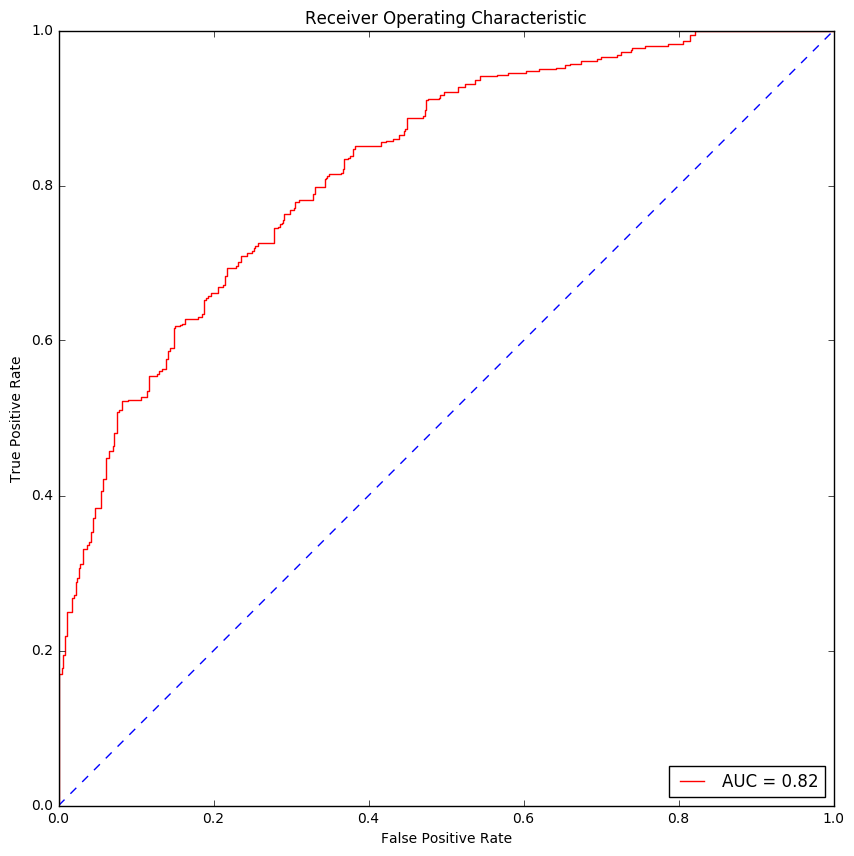

In [98]:
confusion_matrix=metrics.confusion_matrix(y_train,predictions)

auc_roc=metrics.roc_auc_score(y_train,predictions)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, pred_probs[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [90]:
from sklearn.ensemble import RandomForestRegressor
names = df_pred.columns
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))
x = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True)

Features sorted by their score:
[(0.20250000000000001, 'NWins'), (0.068900000000000003, 'elo_diff'), (0.054300000000000001, 'Last'), (0.041399999999999999, 'Wpf'), (0.035299999999999998, 'Lspr'), (0.031899999999999998, 'Tfgp5'), (0.0304, 'Wblk'), (0.027099999999999999, 'Wspr'), (0.026599999999999999, 'Tfgp10'), (0.025600000000000001, 'Lftp'), (0.025399999999999999, 'tourney_diff'), (0.025100000000000001, 'Lto'), (0.0229, 'Lor'), (0.022700000000000001, 'Lfg3p'), (0.021999999999999999, 'Lstl'), (0.021000000000000001, 'Lpf'), (0.020400000000000001, 'Wdr'), (0.020199999999999999, 'NLoss'), (0.019, 'Lfgm3'), (0.018700000000000001, 'Wfgp'), (0.018499999999999999, 'Wftp'), (0.018200000000000001, 'Wfgm'), (0.016899999999999998, 'Wstl'), (0.016, 'Wor'), (0.016, 'Tfgp15'), (0.015800000000000002, 'Wto'), (0.014800000000000001, 'Lfgm'), (0.014800000000000001, 'Lblk'), (0.0143, 'Wast'), (0.014, 'Lfgp'), (0.0129, 'Wftm'), (0.012800000000000001, 'Wfg3p'), (0.0126, 'Ldr'), (0.0121, 'Wfgm3'), (0.0121, 

In [241]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
#use linear regression as the model
lr = LinearRegression()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X_train,y_train)
 
print ("Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names)))

Features sorted by their rank:
[(1, 'NLoss'), (2, 'Wast'), (3, 'Last'), (4, 'Wpf'), (5, 'Lspr'), (6, 'Wto'), (7, 'Lftp'), (8, 'Lor'), (9, 'Wor'), (10, 'Wspr'), (11, 'Lfgp'), (12, 'Wftp'), (13, 'Lto'), (14, 'Ldr'), (15, 'NWins'), (16, 'Lpf'), (17, 'Lfg3p'), (18, 'Wfgp'), (19, 'Wstl'), (20, 'Wblk'), (21, 'Wdr'), (22, 'Lstl'), (23, 'Wfg3p'), (24, 'Lblk')]


In [242]:
from sklearn.linear_model import RandomizedLasso
from sklearn.datasets import load_boston

rlasso = RandomizedLasso(alpha=0.025)
rlasso.fit(X_train, y_train)
 
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), 
                 names), reverse=True))

Features sorted by their score:
[(0.0, 'Wto'), (0.0, 'Wstl'), (0.0, 'Wspr'), (0.0, 'Wpf'), (0.0, 'Wor'), (0.0, 'Wftp'), (0.0, 'Wfgp'), (0.0, 'Wfg3p'), (0.0, 'Wdr'), (0.0, 'Wblk'), (0.0, 'Wast'), (0.0, 'NWins'), (0.0, 'NLoss'), (0.0, 'Lto'), (0.0, 'Lstl'), (0.0, 'Lspr'), (0.0, 'Lpf'), (0.0, 'Lor'), (0.0, 'Lftp'), (0.0, 'Lfgp'), (0.0, 'Lfg3p'), (0.0, 'Ldr'), (0.0, 'Lblk'), (0.0, 'Last')]


In [99]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=50, p=2, weights = 'distance')
kf = KFold(n_splits = 5, shuffle = True, random_state=8)

#print(knn.get_params().keys())

#params = {'C': np.logspace(start=-5, stop=3, num=9)}
# model_LR = GridSearchCV(knn, params, scoring='neg_log_loss', refit=True)
knn.fit(X_train,y_train)

#pred_probs = knn.predict_proba(X_train)
predictions = knn.predict(X_train)

# accuracies = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=kf)
# average_accuracies = np.mean(accuracies)
# print(average_accuracies)

actual = y_train
count= ((predictions-actual)**2).sum()
mse = count/len(actual)
print(mse)

loss = log_loss(y_train, predictions)
print(loss)


0.0
9.99200722163e-16


In [129]:
#predict
df_sample_sub = pd.read_csv(direct+csv[8])

n_test_games = len(df_sample_sub)
print(f_df.shape)


def get_year_t1_t2(id):
    return (int(x) for x in id.split('_'))

# df_diff = create_diff_table(df_tour)
# df_diff.head()

X_test = np.zeros(shape=(n_test_games, 25))
X_test = pd.DataFrame()
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.Id)
    df_calc = f_df[(f_df['Season'] == year)|(f_df['Season'] == year-1)]
    t1_stat = (df_calc.loc[f_df['Team'] == t1]).mean()
    t2_stat = (df_calc.loc[f_df['Team'] == t2]).mean()
    diff = pd.DataFrame(t1_stat.values - t2_stat.values)
    diff = diff.transpose()
    diff['tourney_diff'] = get_tourney_diff(t1,t2,season)
    diff['elo_diff'] = get_elo_diff(t1,t2,season)
    X_test = X_test.append([diff], ignore_index= True)
X_test.head()

#try with 2 seasons, 1 season, no seasons
#df_sample_sub.head()

(3177, 32)


,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,tourney_diff,elo_diff
0,0.0,-4.0,0.031413,-0.001380,-0.001637,0.009906,0.012943,0.005511,-0.892977,0.360322,...,0.069444,-1.985405,-0.818267,-2.153955,-0.086864,-0.383710,-46.0,3.617938,0,123
1,0.0,-12.0,0.031825,0.014662,0.011325,-0.003714,0.007171,0.010548,-1.650878,0.590513,...,-0.414427,-1.070789,-0.431900,-1.491935,0.173387,-1.011649,-21.0,1.052419,0,17
2,0.0,-25.0,0.027775,-0.044341,-0.028435,0.015373,0.002123,-0.016527,1.466094,-0.733381,...,0.213589,0.350601,0.439940,-0.695946,0.652027,-1.185435,-39.0,1.762387,0,240
3,0.0,-27.0,-0.031986,-0.006242,-0.007376,0.011718,0.030068,0.013670,0.427863,1.435282,...,0.751797,-0.451307,0.744444,-0.722549,1.672059,-0.292484,-13.0,1.065196,0,-93
4,0.0,-41.0,0.074528,0.036781,0.031761,0.027328,0.040545,0.050168,-2.350135,1.088773,...,0.698658,-0.567104,-0.752185,0.302434,2.119382,-0.291823,-17.0,1.255150,0,58


In [130]:
X_test.drop([0,1],inplace = True, axis =1)
X_test.shape

(2278, 32)

In [132]:
X_test=scaler.fit_transform(X_test)
preds = knn.predict(X_test)

clipped_preds = np.clip(preds, 0.025, 0.975)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head(20)

# X_test=scaler.fit_transform(X_test)
# preds = model_LR.predict_proba(X_test)[:,1]

# clipped_preds = np.clip(preds, 0.025, 0.975)
# df_sample_sub.pred = clipped_preds
# df_sample_sub.head(20)

,Id,Pred
0,2017_1112_1116,0.737688
1,2017_1112_1124,0.418380
2,2017_1112_1137,0.941528
3,2017_1112_1139,0.629238
4,2017_1112_1153,0.698455
5,2017_1112_1166,0.560248
6,2017_1112_1173,0.664306
7,2017_1112_1181,0.513324
8,2017_1112_1190,0.670839
9,2017_1112_1195,0.866902


In [133]:
df_sample_sub.to_csv('danny_mm_17_4_KNN_Final.csv', index=False)

In [123]:
x = df_sample_sub[:-2273]
x.shape

(6839, 2)

In [97]:
from sklearn.neighbors import KNeighborsRegressor
# Create the knn model.
# i1 = []
# mse1 = []
#for i in range(1,300):
knn = KNeighborsRegressor(n_neighbors=1, algorithm = 'ball_tree', leaf_size = 10)
# Fit the model on the training data.
knn.fit(X_train, y_train)
# Make predictions on the test set using the fit model.
predictions = knn.predict(X_train)
print(predictions)
# for y in range(len(predictions)):
#     if predictions[y] >= 0.5:
#         predictions[y] = 1
#     else:
#         predictions[y] = 0

actual = y_train
count= ((predictions-actual)**2).sum()
mse = count/len(actual)
print(mse)


accuracies = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=10)
average_accuracies = np.mean(accuracies)
print(average_accuracies)


loss = log_loss(y_train, predictions)
print(loss)

# i1.append(i)
# mse1.append(mse)
# print(predictions)
#print(i1)

[ 1.  1.  1.  1.  1.  1.  0.  1.  0.  0.  1.  1.  1.  1.  0.  1.  0.  0.
  1.  1.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.
  0.  1.  0.  0.  1.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  0.  0.  1.  1.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.
  1.  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  1.  1.  0.  0.  0.  1.  1.  0.  0.  1.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  0.  1.  1.
  0.  0.  1.  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  1.  1.
  1.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  1.  0.  1.  1.  1.  0.  0.
  0.  0.  0.  0.  1.  1.  1.  1.  0.  1.  0.  1.  1.  0.  1.  1.  0.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  1.  1.  0.  1.  0.
  0.  1.  1.  0.  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.  0.  1.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  1.  1.  1.  0.  1.  0.  0.  0.
  1.  1.  1.  1.  0.  1.  0.  0.  1.  0.  0.  1.  1

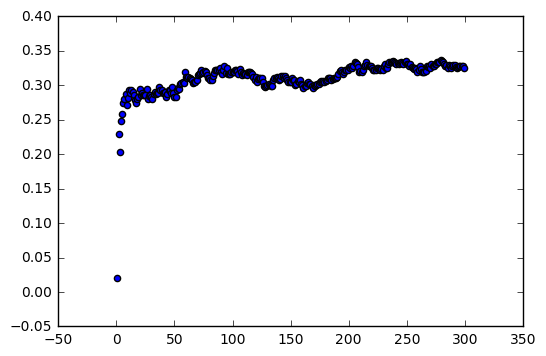

In [291]:
plt.scatter(i1,mse1)